/opt/anaconda3/envs/fakenews/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: divide by zero encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/opt/anaconda3/envs/fakenews/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: overflow encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
/opt/anaconda3/envs/fakenews/lib/python3.10/site-packages/sklearn/linear_model/_linear_loss.py:209: RuntimeWarning: invalid value encountered in matmul
  norm2_w = weights @ weights if weights.ndim == 1 else squared_norm(weights)
2025/07/25 15:52:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/25 15:52:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


              precision    recall  f1-score   support

           0      0.986     0.994     0.990      4284
           1      0.995     0.987     0.991      4696

    accuracy                          0.990      8980
   macro avg      0.990     0.990     0.990      8980
weighted avg      0.990     0.990     0.990      8980

AUC  = 0.999


/opt/anaconda3/envs/fakenews/lib/python3.10/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


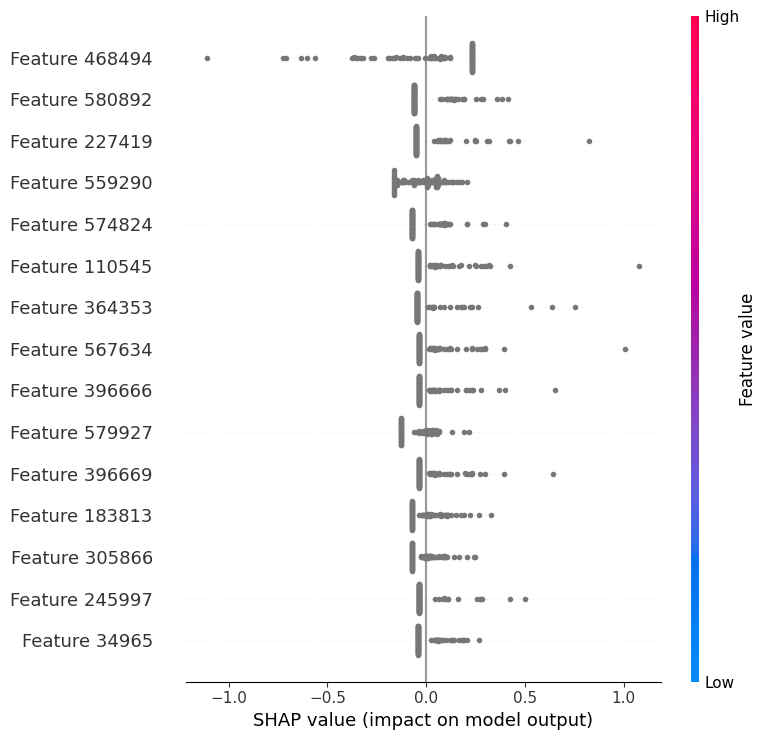

In [3]:
import pandas as pd, joblib, mlflow
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score

df = pd.read_parquet("../data/processed/news.parquet")
X_train, X_test, y_train, y_test = train_test_split(
    df["clean"], df["label"], test_size=0.2,
    stratify=df["label"], random_state=42)

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(max_df=0.8, min_df=3, ngram_range=(1,2))),
    ("clf",  LogisticRegression(max_iter=300, class_weight="balanced"))
])

with mlflow.start_run():
    pipe.fit(X_train, y_train)
    mlflow.sklearn.log_model(pipe, "model")
    preds = pipe.predict(X_test)
    auc = roc_auc_score(y_test, pipe.predict_proba(X_test)[:,1])
    print(classification_report(y_test, preds, digits=3))
    print(f"AUC  = {auc:.3f}")
    joblib.dump(pipe, "../models/fake_news_lr.joblib")


import os, shap, matplotlib.pyplot as plt
# Ensure the directory for saving the plot exists
os.makedirs("media", exist_ok=True)
explainer = shap.LinearExplainer(
    pipe.named_steps["clf"],
    pipe.named_steps["tfidf"].transform(df["clean"][:2000]),
    feature_perturbation="interventional")
shap_vals = explainer(pipe.named_steps["tfidf"].transform(df["clean"][:100]))
shap.summary_plot(shap_vals, max_display=15, show=False)
plt.tight_layout(); plt.savefig("media/shap_top15.png", dpi=150)

In [4]:
df_out = df[["title", "label"]]
df_out["pred_proba"] = pipe.predict_proba(df["clean"])[:,1]
df_out.to_csv("../data/processed/powerbi_news.csv", index=False)
print("✅  powerbi_news.csv ready for import")

✅  powerbi_news.csv ready for import


/var/folders/mp/l6mvsv6n7yvgqz458f3_nb4c0000gn/T/ipykernel_10817/2669205683.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_out["pred_proba"] = pipe.predict_proba(df["clean"])[:,1]
